In [1]:
import numpy as np
import pylab as plt
import torch
from tqdm.auto import tqdm
import scipy.linalg
import pandas as pd
import torchvision.datasets as dst

from common import gsave, gload
from nde.kernels import load_fmnist_all, KernelPredictor, KernelType

In [2]:
def load_mnist():
    train_ds = dst.MNIST(root='~/tmp/data', train=True,
                                download=True, transform=None)
    test_ds = dst.MNIST(root='~/tmp/data', train=False,
                               download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

def load_mnist_all():
    X_tr, Y_tr, X_te, Y_te = load_mnist()
    X = np.concatenate((X_tr, X_te)).astype(np.float32)
    Y = np.concatenate((Y_tr, Y_te))
    return X, Y

In [3]:
X, Y = load_mnist_all()
ker = KernelPredictor(X, Y)

In [4]:
ker.D.dtype

dtype('float32')

In [5]:
def joint_density(Y, L, num_classes=None):
    '''
        Estimates the joint density of (Y, L)
        where Y \in [nY],  L \in [nL].

        In other words, returns the confusion matrix.
    '''
    if num_classes is None:
        nY=np.max(Y)+1
        nL=np.max(L)+1
    else:
        nY = nL = num_classes
        
    C = np.zeros((nY, nL))
    for yhat, ell in zip(Y, L):
        C[yhat, ell] += 1
    C /= np.sum(C)
    return C

def apply_noise(Y, confusion_matx):
    C = torch.Tensor(confusion_matx)  # C[i, j] = Pr[j --> i]
    Y_new = np.empty_like(Y)
    for i in range(len(Y)):
        y = Y[i]
        p = C[:, y]
        yNew = torch.distributions.categorical.Categorical(probs=p).sample()
        #print(p)
        Y_new[i] = yNew
    return Y_new

def plot_confusion(cm, display_labels=None, include_values=True, cmap='viridis',
         xticks_rotation='horizontal', values_format=None, ax=None):
    """Plot visualization. 
    https://github.com/scikit-learn/scikit-learn/blob/483cd3eaa/sklearn/metrics/_plot/confusion_matrix.py#L11
    """
    
    cm = cm.T # TRANSPOSE
    n_classes = cm.shape[0]
    
    import matplotlib.pyplot as plt
    from itertools import product

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    text_ = None
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    if include_values:
        text_ = np.empty_like(cm, dtype=object)

        # print text with appropriate color depending on background
        thresh = (cm.max() + cm.min()) / 2.0

        for i, j in product(range(n_classes), range(n_classes)):
            color = cmap_max if cm[i, j] < thresh else cmap_min

            if values_format is None:
                text_cm = format(cm[i, j], '.2g')
                if cm.dtype.kind != 'f':
                    text_d = format(cm[i, j], 'd')
                    if len(text_d) < len(text_cm):
                        text_cm = text_d
            else:
                text_cm = format(cm[i, j], values_format)

            text_[i, j] = ax.text(
                j, i, text_cm,
                ha="center", va="center",
                color=color)

    if display_labels is None:
        display_labels = np.arange(n_classes)

    #fig.colorbar(self.im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

    return (fig, ax)

In [74]:
## SETUP

ntr = 10000 # 60000
I_tr = list(range(0, ntr))
I_te = list(range(60000, 70000))
ktype = KernelType.GAUSSIAN
sigma=0.15

Kte = ker.d_to_K(ker.D[I_te, :][:, I_tr], ktype, sigma)
Ktr = ker.d_to_K(ker.D[I_tr, :][:, I_tr], ktype, sigma)

y_tr = ker.y[I_tr]
y_te = ker.y[I_te]

def train(y_tr, nc=10):
    Y = np.eye(nc)[y_tr]
    model = scipy.linalg.solve(Ktr, Y, sym_pos=True, check_finite=False)
    yhats = Kte.dot(model)
    preds = np.argmax(yhats, axis=1)
    return preds

In [75]:
## SVM

def train_svm(y_tr, C = 1.0):
    from sklearn.svm import SVC
    clf = SVC(kernel = "precomputed", C = C, cache_size = 100000)
    clf.fit(Ktr, y_tr)
    preds = clf.predict(Kte)
    return preds

def train_svm2(y_tr, C=1.0):
    from sklearn.svm import SVC
    clf = SVC(kernel = "precomputed", C = C, cache_size = 100000)
    clf.fit(Ktr, y_tr)
    predsTe = clf.predict(Kte)
    predsTr = clf.predict(Ktr)
    return predsTe, predsTr

predsTe, predsTr = train_svm2(y_tr, C = 0.01)
print('SVM train acc:', (predsTr == y_tr).mean())
print('SVM test acc:', (predsTe == y_te).mean())

SVM train acc: 0.6931
SVM test acc: 0.6705


Text(0, 0.5, 'test acc')

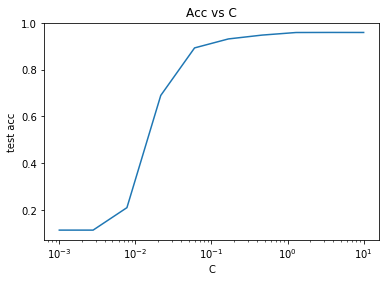

In [15]:
## calibtrate SVM 'C' value

cs = 10**np.linspace(-3, 1, 10)
accs = [(train_svm(y_tr, C = c)== y_te).mean() for c in tqdm(cs)]
plt.semilogx(cs, accs);
plt.title('Acc vs C');
plt.xlabel('C');
plt.ylabel('test acc')

In [63]:
## SINGLE confusion matrix
C = np.eye(10) # C[i, j] = Pr[j --> i]
C[1, 0] = 0.45
C[0, 0] = 0.55

y_tr = ker.y[I_tr]
y_tr_orig = np.copy(y_tr)
y_tr = apply_noise(y_tr_orig, C)

print('len(tr):', len(y_tr))

predsTe, predsTr = train_svm2(y_tr, C = 10.0)

print('SVM train acc:', (predsTr == y_tr).mean())
print('SVM test acc:', (predsTe == y_te).mean())

len(tr): 10000
SVM train acc: 1.0
SVM test acc: 0.9307


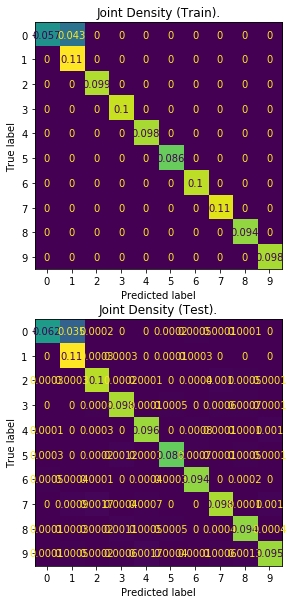

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

cm_tr = joint_density(predsTr, y_tr_orig, num_classes=10)
cm_te = joint_density(predsTe, y_te, num_classes=10)

plot_confusion(cm_tr, ax=axs[0], display_labels=None)
axs[0].set_title(f'Joint Density (Train).');
plot_confusion(cm_te, ax=axs[1], display_labels=None)
axs[1].set_title(f'Joint Density (Test).');

In [71]:
## ARRAY of CMs
C_svm = 10.0

res = []

ps = np.linspace(0, 1, 11)
for p in ps:
    C = np.eye(10) # C[i, j] = Pr[j --> i]
    C[0, 0] = (1-p)
    C[1, 0] = p

    y_tr_orig = np.copy(ker.y[I_tr])
    y_tr = apply_noise(y_tr_orig, C)

    predsTe, predsTr = train_svm2(y_tr, C = C_svm)
    
    acc    = (predsTe == y_te).mean()
    tr_acc = (predsTr == y_tr).mean()
    print(f'p:{p}\t test acc: {acc} \t train acc: {tr_acc}')
    
    cm_tr_ideal = C.dot(0.1*np.eye(10)) # ideal joint density
    cm_tr = joint_density(predsTr, y_tr_orig, num_classes=10)
    cm_te = joint_density(predsTe, y_te, num_classes=10)
    
    d = {
        'p' : p,
        'acc' : acc,
        'tr_acc' : tr_acc,
        'cm_tr' : cm_tr,
        'cm_te' : cm_te,
        'cm_tr_ideal': cm_tr_ideal}
    
    res.append(d)

p:0.0	 test acc: 0.9857 	 train acc: 1.0
p:0.1	 test acc: 0.9836 	 train acc: 0.9999833333333333
p:0.2	 test acc: 0.9753 	 train acc: 0.9999333333333333
p:0.30000000000000004	 test acc: 0.9661 	 train acc: 0.9999666666666667
p:0.4	 test acc: 0.9475 	 train acc: 0.99995
p:0.5	 test acc: 0.9386 	 train acc: 0.9999666666666667
p:0.6000000000000001	 test acc: 0.92 	 train acc: 0.9999666666666667
p:0.7000000000000001	 test acc: 0.9069 	 train acc: 0.9999333333333333
p:0.8	 test acc: 0.8964 	 train acc: 0.99995
p:0.9	 test acc: 0.8896 	 train acc: 0.9999666666666667
p:1.0	 test acc: 0.8884 	 train acc: 1.0


In [72]:
gsave(res, f'gs://ANONYMOUS/results/nde/kernels/conf/mnist/svm_targ01_C{C_svm}_s{sigma}')

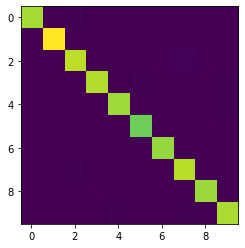

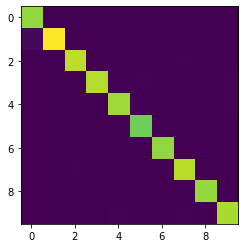

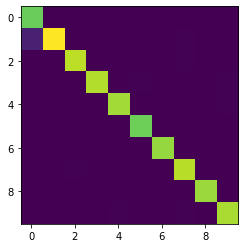

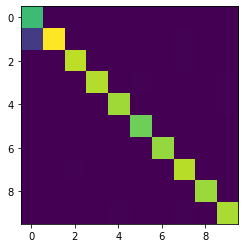

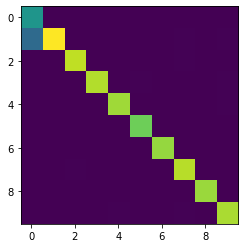

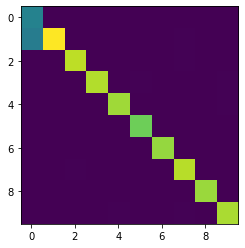

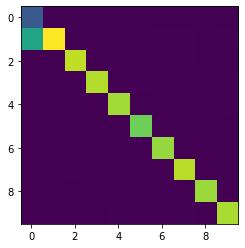

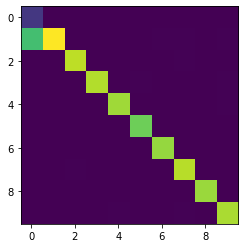

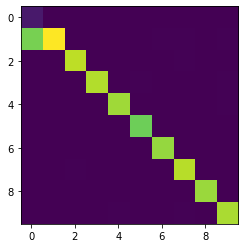

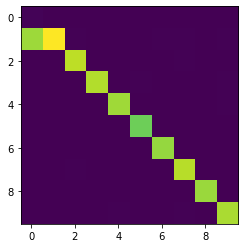

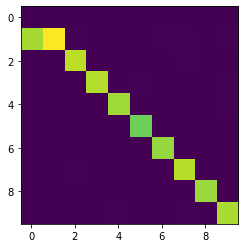

In [73]:
for d in res:
    plt.figure()
    plt.imshow(d['cm_te'])
    #print(d['cm_te'])

## Grid of p x C

In [85]:
exps = np.linspace(-2, 2, 4*2 + 1)
cs = 10**exps
exps

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

In [86]:
## ARRAY of CMs

res = []

exps = np.linspace(-2, 2, 4*2 + 1)
ps = np.linspace(0, 1, 11)
for e in tqdm(exps):
    C_svm = 10**e
    
    for p in ps:
        C = np.eye(10) # C[i, j] = Pr[j --> i]
        C[0, 0] = (1-p)
        C[1, 0] = p

        y_tr_orig = np.copy(ker.y[I_tr])
        y_tr = apply_noise(y_tr_orig, C)

        predsTe, predsTr = train_svm2(y_tr, C = C_svm)

        acc    = (predsTe == y_te).mean()
        tr_acc = (predsTr == y_tr).mean()
        print(f'exp:{e}\t, p:{p}\t test acc: {acc} \t train acc: {tr_acc}')

        cm_tr_ideal = C.dot(0.1*np.eye(10)) # ideal joint density
        cm_tr = joint_density(predsTr, y_tr_orig, num_classes=10)
        cm_te = joint_density(predsTe, y_te, num_classes=10)

        d = {
            'p' : p,
            'C' : C_svm,
            'C_exp': e,
            'acc' : acc,
            'tr_acc' : tr_acc,
            'cm_tr' : cm_tr,
            'cm_te' : cm_te,
            'cm_tr_ideal': cm_tr_ideal}

        res.append(d)

exp:-2.0	, p:0.0	 test acc: 0.6705 	 train acc: 0.6931
exp:-2.0	, p:0.1	 test acc: 0.6572 	 train acc: 0.6739
exp:-2.0	, p:0.2	 test acc: 0.6215 	 train acc: 0.6372
exp:-2.0	, p:0.30000000000000004	 test acc: 0.5829 	 train acc: 0.6018
exp:-2.0	, p:0.4	 test acc: 0.577 	 train acc: 0.6218
exp:-2.0	, p:0.5	 test acc: 0.5497 	 train acc: 0.6112
exp:-2.0	, p:0.6000000000000001	 test acc: 0.4443 	 train acc: 0.5162
exp:-2.0	, p:0.7000000000000001	 test acc: 0.3817 	 train acc: 0.4693
exp:-2.0	, p:0.8	 test acc: 0.3651 	 train acc: 0.4621
exp:-2.0	, p:0.9	 test acc: 0.3518 	 train acc: 0.4564
exp:-2.0	, p:1.0	 test acc: 0.3376 	 train acc: 0.4513
exp:-1.5	, p:0.0	 test acc: 0.8954 	 train acc: 0.9035
exp:-1.5	, p:0.1	 test acc: 0.8952 	 train acc: 0.8944
exp:-1.5	, p:0.2	 test acc: 0.8937 	 train acc: 0.8845
exp:-1.5	, p:0.30000000000000004	 test acc: 0.8925 	 train acc: 0.8718
exp:-1.5	, p:0.4	 test acc: 0.8858 	 train acc: 0.8605
exp:-1.5	, p:0.5	 test acc: 0.7997 	 train acc: 0.8549
exp:

In [87]:
gsave(res, f'gs://ANONYMOUS/results/nde/kernels/conf/mnist/svm_grid_targ01_N{ntr}_s{sigma}')